# PreProcessing, EDA and Feature extraction notebook

## Importing libraries and packages installation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import json
import re
import string
from tqdm import tqdm
import sys
import subprocess
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
from datasets import load_dataset
import unicodedata
import contractions
from scipy.stats import pearsonr

/opt/anaconda3/envs/NLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check and install required packages
def install_package(package):
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [3]:
# Install transformers for BERT if necessary
try:
    import torch
    from transformers import AutoTokenizer, AutoModel, pipeline
except ImportError:
    print("Installing required packages for BERT...")
    install_package("torch")
    install_package("transformers")
    import torch
    from transformers import AutoTokenizer, AutoModel, pipeline

In [4]:
# Install sentence-transformers for sentence embeddings
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    install_package("sentence-transformers")
    from sentence_transformers import SentenceTransformer

In [5]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Load dataset and apply preprocessing
print("Loading dataset...")
df = load_dataset("ayjays132/Emotionverse")
df = pd.DataFrame(df['train'])

Loading dataset...


In [7]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /Users/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Initialize NLTK resources
stop_words = set(stopwords.words('english')) - {"no", "not", "nor","never"}
lemmatizer = WordNetLemmatizer()

## PreProcessing

In [9]:
# Preprocessing functions
def normalize_unicode(text):
    return unicodedata.normalize("NFKD", text)

def clean_text(text):
    text = normalize_unicode(text)
    #text = contractions.fix(text)  # Expand contractions: I'm → I am
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#", "", text)  # Remove hashtag symbols (keep word)
    text = re.sub(r"[^\w\s!?',.]", " ", text)  # Keep ! ? ' , . for emotion and sentence structure
    return text

def to_lowercase(text):
    return text.lower()

def handle_negation(tokens):
    """
    Modify tokens following negation words to capture sentiment impact,
    with continued negation tracking across punctuation.
    
    Parameters:
    -----------
    tokens : list
        List of tokens in a sentence
    
    Returns:
    --------
    list
        Tokens with negation handling applied
    """
    # Negation words that trigger modification
    negation_words = {'not', 'no', 'never', 'neither', 'hardly', 'scarcely'}
    
    # Punctuation that might interrupt token processing
    stop_punctuation = {',', '.', '!', '?'}
    
    modified_tokens = []
    is_negated = False
    i = 0
    
    while i < len(tokens):
        # Check if current token is a negation word
        if tokens[i].lower() in negation_words:
            # Toggle negation state
            is_negated = not is_negated
            modified_tokens.append(tokens[i])
        
        # Apply negation prefix if currently in negated state
        elif is_negated:
            # Check if token is punctuation
            if tokens[i] in stop_punctuation:
                # If punctuation, reset negation state
                is_negated = False
                modified_tokens.append(tokens[i])
            else:
                # Prefix token with NOT_
                modified_tokens.append(f'NOT_{tokens[i]}')
        
        # Normal token processing when not negated
        else:
            modified_tokens.append(tokens[i])
        
        # Move to next token
        i += 1
    
    return modified_tokens


In [10]:
def preprocess_text_pipeline(text):
    # Apply string-based cleaning first
    text = clean_text(text)
    text = to_lowercase(text)
    # Then tokenize
    tokens = word_tokenize(text)
    
    # Process tokens
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = handle_negation(tokens)
    tokens = [token for token in tokens if token not in (",",".")]

    # Join back to string
    return " ".join(tokens)

In [11]:
# Apply preprocessing
print("Applying preprocessing...")
df['clean_text'] = df['text'].apply(preprocess_text_pipeline)
print(f"Total of {len(df)} documents processed")

Applying preprocessing...
Total of 1874 documents processed


## EDA

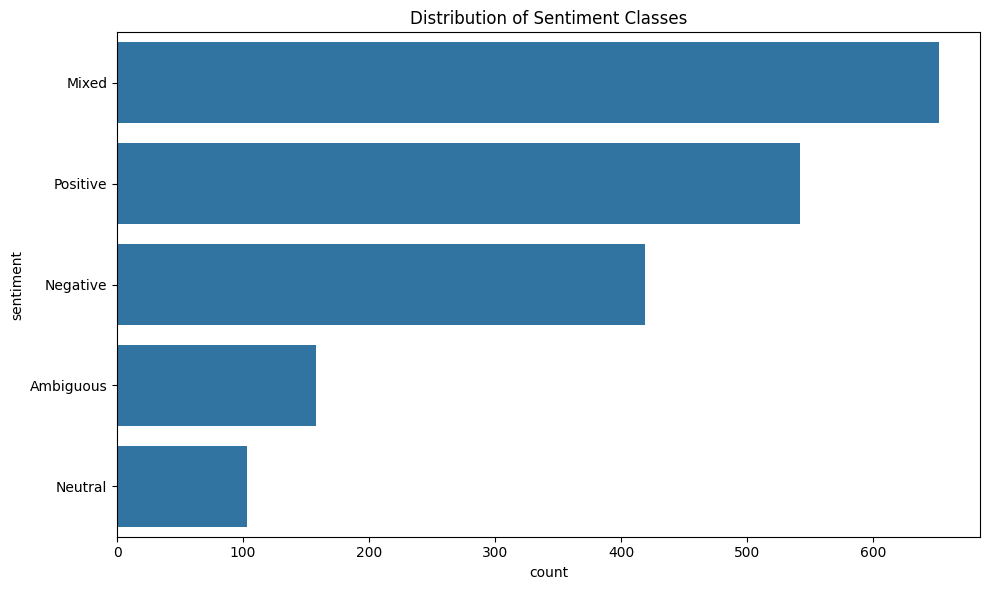

In [12]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Classes')
plt.tight_layout()
plt.show()

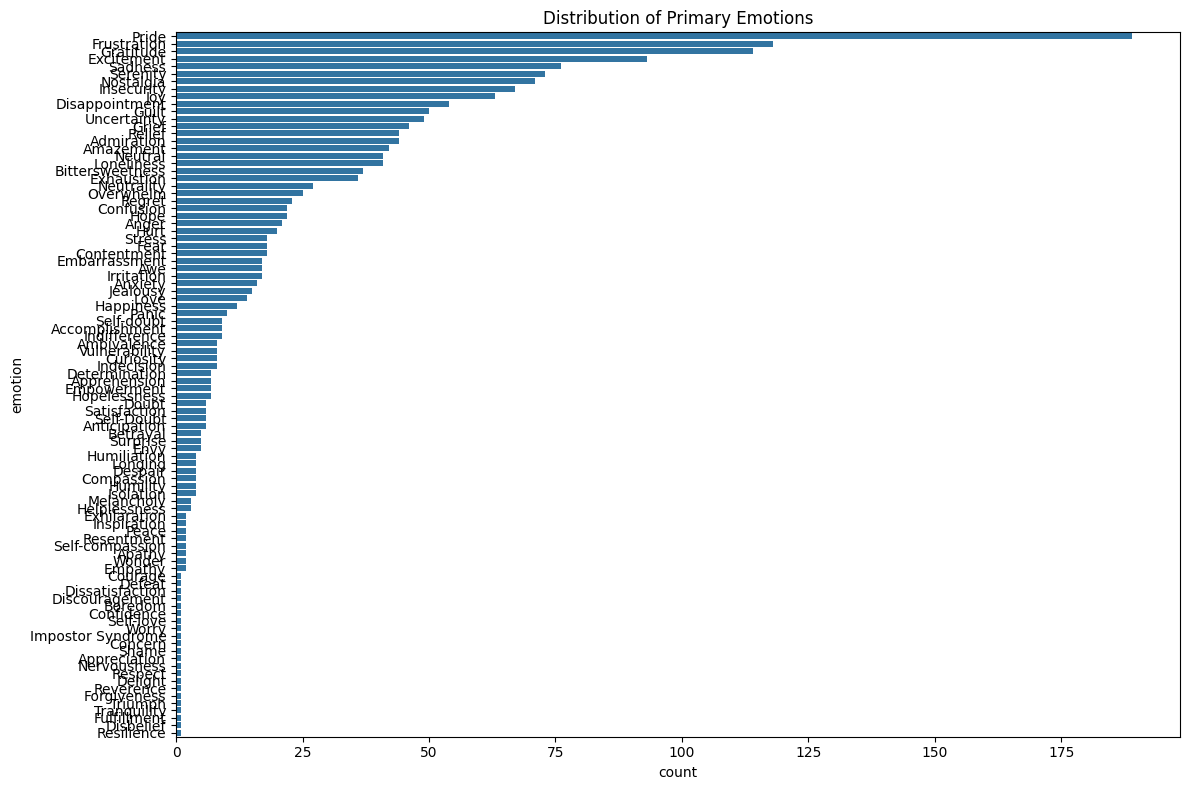

In [13]:
# Visualize primary emotions
plt.figure(figsize=(12, 8))
emotion_counts = Counter(df['primary_emotion'])
emotion_df = pd.DataFrame({'emotion': list(emotion_counts.keys()), 
                           'count': list(emotion_counts.values())})
emotion_df = emotion_df.sort_values('count', ascending=False)
sns.barplot(x='count', y='emotion', data=emotion_df)
plt.title('Distribution of Primary Emotions')
plt.tight_layout()
plt.show()

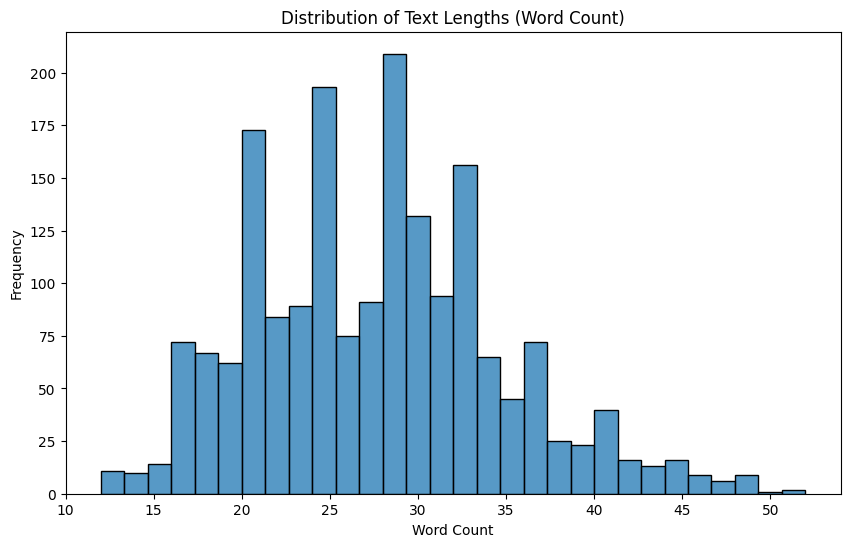

In [14]:
# Text length distribution
plt.figure(figsize=(10, 6))
text_lengths = [len(text.split()) for text in df['text']]
sns.histplot(text_lengths, bins=30)
plt.title('Distribution of Text Lengths (Word Count)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


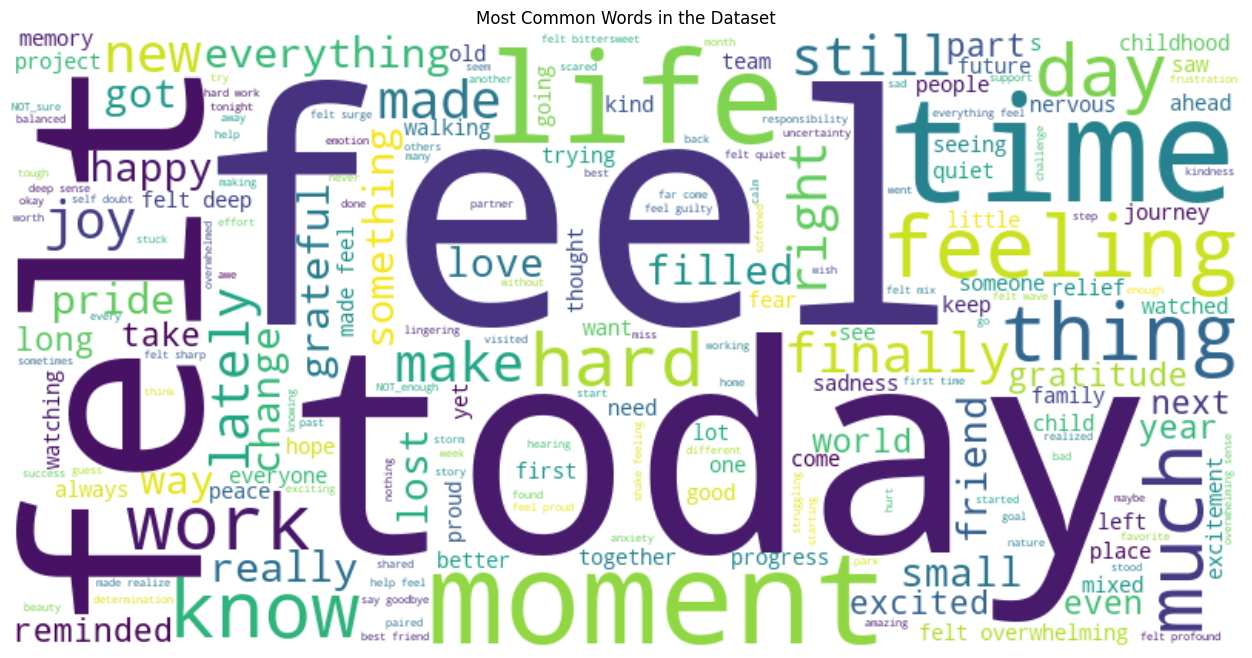

In [15]:
# Word cloud for visualizing common terms
all_text = ' '.join(df['clean_text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in the Dataset')
plt.show()


In [16]:
df.to_csv('clean.csv')

df["clean_text"]

0       proud friend overcoming struggle make wonder e...
1       finally finished project ! exhausting thrilled...
2       laughter shared reunion best part week miss mo...
3          everything feel uncertain right ? wish clarity
4       graduation feel exciting sad end something bea...
                              ...                        
1869    feel like lost sight truly matter need take st...
1870    excited see family long way long since got tog...
1871      shake nagging feeling not NOT_enough exhausting
1872    love rainy day give chance relax reflect every...
1873    feeling little stuck lately like rut hard brea...
Name: clean_text, Length: 1874, dtype: object